# 순서
### import modules
### methods
### predictor 초기화
### 전처리

In [1]:
!pwd

/aiffel/aiffel/aiffeltonprj/detectron/detectron2


In [2]:
!mkdir U_2_Net

mkdir: cannot create directory ‘U_2_Net’: File exists


In [3]:
!git clone https://github.com/NathanUA/U-2-Net.git U_2_Net

fatal: destination path 'U_2_Net' already exists and is not an empty directory.


In [4]:
%cd U_2_Net

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/U_2_Net


In [5]:
!git clone https://github.com/NKAnzu/TDWV.git
!mv TDWV/u2net_human_seg_TDWV.py ./

fatal: destination path 'TDWV' already exists and is not an empty directory.
mv: cannot stat 'TDWV/u2net_human_seg_TDWV.py': No such file or directory


In [6]:
import U_2_Net.u2net_human_seg_TDWV
import U_2_Net.data_loader

In [7]:
%cd U_2_Net/saved_models/
!mkdir u2net_human_seg


[Errno 2] No such file or directory: 'U_2_Net/saved_models/'
/aiffel/aiffel/aiffeltonprj/detectron/detectron2/U_2_Net
mkdir: cannot create directory ‘u2net_human_seg’: File exists


In [8]:
!pwd

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/U_2_Net


In [9]:
%cd ../

/aiffel/aiffel/aiffeltonprj/detectron/detectron2


# 설치
# 다음의 파일 다운받아 saved_models/u2net_human_seg/에 업로드 해주세요

https://drive.google.com/file/d/1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P/view

# U_2_Net에 u2net_human_seg_TDWV upload 후 import 

https://github.com/NKAnzu/TDWV/blob/main/u2net_human_seg_TDWV.py
u2net_human_seg_TDWV.py



In [10]:
!pip install imutils
!pip install pycocotools

In [11]:
!pwd

/aiffel/aiffel/aiffeltonprj/detectron/detectron2


# import modules

In [12]:
# inference
import torch
import numpy as np
import cv2
import detectron2
import imutils
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt


from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.logger import setup_logger
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import Instances
from detectron2.data.transforms import Resize
from detectron2.engine import DefaultPredictor

#pose estimation
from PIL import Image
import PIL 
import tqdm
setup_logger()
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo


# methods 선언

cal_margin, set_margin, cal_by_x, onlykeeppersonclass

In [13]:
def cal_margin(a1, a2, m, i, im):
    if a1 - m <= 0 :  #왼쪽 부족
        rest_a = m-a1 #이게 지금 문제, x<=m일때, rest_x = m-(m-x)
        a1 = 0
        #print("1", rest_a)
        #오른쪽이 충분하건 부족하건 끝내면 됨
        if a2+ rest_a+ m >= im.shape[i]: #오른쪽 부족 - 왼쪽은 이미 부족
            w = im.shape[i]-a1
            a2 = im.shape[i]
            rest_a = a2+rest_a+m - im.shape[i]

        else: #오른쪽 충분
            a2 = a2+rest_a+m
            rest_a = 0



    elif a1 - m > 0: #왼쪽 충분
        a1 = a1-m
        rest_a = 0 #rest_x는 0

        #오른쪽이 부족할경우 다시 수행해야함.
        if a2+ rest_a+ m >= im.shape[i]: #오른쪽 부족
            rest_a = m- (im.shape[i] - a2) #오른쪽 처리못하고 남은 마진
            a2 = im.shape[i]

            if a1-rest_a <=0: #오른쪽에서 남은 마진을 왼쪽에서 처리하기에 부족 - 이제 양쪽 모두 불가능 - 그대로 끝
                a1=0
                rest_a = rest_a - a1
            else: #왼쪽 안부족 - 왼쪽에서 남은 마진만큼 더 빼서 설정.
                a1=a1-rest_a
                rest_a = 0

        else: #오른쪽 충분
            rest_a = 0
            a2 = a2 + rest_a+m

    tmp = a2-a1

    return a1, a2, tmp
        

def set_margin(x, y, x2, y2, m, im): #cal_margin 사용
    #x point조정 - 양쪽을 늘리는것을 최우선으로 하자. 그게 안될경우 한쪽 한쪽, 둘다 안될경우 이렇게 나누기
    #연산을 할때, 우려되는 경우의수 왼쪽부족->오른쪽부족 , 왼쪽충분->오른쪽부족 마지막에 rest_x가 남게됨
    #이를 어떻게 해결할까 - 왼쪽부족->오른쪽부족은 그냥 그대로 냅두면 됨
    #왼충 오부는 왼쪽에 다시 할당을 하러 오면 된다.
    #print("before margin x,y,x2,y2 = ", x, y, x2, y2)
    #w길이에 대해서 다시 봐야한다.
    x,x2,w = cal_margin(x,x2,m,1,im)
    y,y2,h = cal_margin(y,y2,m,0,im)
    
    #print("x,y,x2,y2, w, h", x, y, x2, y2, w, h)
    
    return x,y,x2,y2,w,h


#사용하는 메소드
def cal_by_x(x,x2,w,i,im): # i는 im.shape[i]의 비교대상 - height는 고정, width 기준 비교라면 i=0
    margin_left = (192-w)/2 # 중앙점에서 한쪽의 w/2 를 뺴고 남은 앞으로 더 빼야할 양 -> 이값이 음수면 
    margin_right = (192-w)/2 # 중앙점에서 한쪽의 w/2 뺴고 남은 앞으로 더 뺴야할 양
    

    if x - margin_left < 0:  # x-margin_left가 이미지 왼쪽 벽보다 더 가면 x = 0으로 놔야함 , margin_left도 남는다. 
        margin_transfer = margin_left - x
        margin_left = 0
        margin_right += margin_transfer
        x = 0

        if x2 + margin_right > im.shape[i]: # x2 + margin_right가 이미지 오른쪽 벽보다 더 가면 x2 = im.shape[1]로 놔야함. margin_right도 남음 but 처리불가
            # 0 ~ im.shape[1]
            margin_right = x2 + margin_right - im.shape[i]
            x2 = im.shape[i]

            #margin처리를 더 할수 없는 상황이다. 이럴때는 어떻게 처리해야할까?? 일단 그냥처리 // 다른방법은.. 비율로만 맞추는방법 그후


        else: # x2 + margin_right 그대로 x2에 저장, margin은 더이상 남지 않는다.
            # 0 ~ 192 (x2 + margin_right)
            x2 = x2 + margin_right
            margin_right=0
            margin_transfer=0

    else: # x > margin_left일 경우, 둘의 차가 이미지 왼쪽 벽에 닿지 않음 즉 margin_left는 남지 않는다
        x = x - margin_left
        margin_left=0

        if x2 + margin_right > im.shape[i]: # 이미지 오른쪽 벽을 넘어감
            # x-margin_left ~ im.shape[1]
            margin_transfer = x2 + margin_right - im.shape[i]
            margin_right = 0
            x2 = im.shape[i]

            if x - margin_transfer < 0: #왼쪽 벽 막힘
                margin_transfer=0
                x=0
            else:
                x = x - margin_transfer
                margin_transfer=0

        else: # 이미지 오른쪽 안넘음
            # x-margin_left ~ x2 + margin_right
            x2 = x2 + margin_right
            margin_right = 0
    #print("x2 - x = w", x2, x, w)
    w = x2 - x

    return x,x2,w


def onlykeeppersonclass(outputs, im, edge_im,label_im): #set_margin -> cal_margin
    
    # 해당하는 마스크만 남김.
    print("instances", outputs['instances'].pred_classes[0])
    
    num_masks = outputs['instances'].pred_masks.shape[0]
    #print(outputs['instances'])
    min_false_elements = np.inf
    min_false_idx = None
    
    for i in range(num_masks):
        mask = outputs['instances'].pred_masks[i]
        num_false_elements = np.sum(mask == 'False')
        if num_false_elements < min_false_elements:
            min_false_elements = num_false_elements
            min_false_idx = i
    
    #masks = outputs['instances'].pred_masks[min_false_idx:min_false_idx+1]
    
    
    #print(outputs['instances'].pred_masks.shape)
    
    
    #class가 사람인것 + bbox 넓이 가장 큰것 선택
    max_index=0
    max_area=0
    #print("outputs",outputs['instances'])
    for i,bbox in enumerate(outputs['instances'].pred_boxes): #x,y x2, y2
        #선택한 class가 사람인가?
        if int(outputs['instances'].pred_classes[i]) != 0: 
            continue
            
        #선택한 bbox가 넓이가 가장 큰가?
        if max_area == 0:
            max_index = i
            max_area = (bbox[3]-bbox[1])*(bbox[2]-bbox[0]) # x2 - x1 * y2 - y1
            #print("max:",max_area)
            continue
        area = (bbox[3]-bbox[1])*(bbox[2]-bbox[0])
        #print("area",area)
        if max_area < area:
            max_index = i
            max_area = area
    
    
    ##왼쪽이 불충분한 mask##
    masks = outputs['instances'].pred_masks[max_index:max_index+1]
    cls = outputs['instances'].pred_classes[max_index]
    scores = outputs["instances"].scores[max_index]
    boxes = outputs['instances'].pred_boxes[max_index]
    
    
    #print(boxes)
    for i, box in enumerate(boxes):
    # get the x, y, width, and height of the bbox
        x, y, x2, y2 = box.tolist()
    
    x,y,x2,y2 = int(x), int(y), int(x2), int(y2)
    ##print("box x, y, x2, y2",x,y,x2,y2)
    
    
    #바로 resize하기전에 앞서,이 이미지의 id에 해당하는 annotation을 불러오고
    
    
    
    #불러온 annotation의 bbox를 아래에 나올 ratio에 맞게 같이 resize 해야한다.
    
    #헌데 지금 생각나는 이미지 불러오는방식은 파일의 이미지-> 동일한 image_id의 annotation을 참고해 seg를 crop인데,
    #지금 index 들어가는 방식이 [0] 후에 id를 하나만 접근 가능해 이 annotation을 먼저 참고해서 image_id가 같은 아이템을 변경해야함
    
    
    
    
    
    
    #1. 먼저 margin을 준다. - set_margin
    m = 10 #margin
    x,y,x2,y2,w,h = set_margin(x,y,x2,y2,m,im)
    
 
    ##print("after margin x,y,x2,y2 = ", x, y, x2, y2)
    ##print("after margin x, y, w, h ", x, y, w, h)
    
    #2. resize -> cal_by_x, cal_by_y를 통해 width x height를 192 x 256으로 고정한다.
    
    ratio = 256 / h 
    
    ##print("before resize img size =", im.shape)
    im = imutils.resize(im, height=int(im.shape[0]*ratio))
    edge_im = imutils.resize(edge_im, height=int(edge_im.shape[0]*ratio))
    label_im = imutils.resize(label_im, height=int(label_im.shape[0]*ratio))
    ##print("after resize img size =", im.shape)
    
    w = round(w*ratio)
    h = round(h*ratio)
    ##print("after resize bbox w = ", w)
    ##print("after resize bbox h = ", h)
    
    x = int(x*ratio)
    y = int(y*ratio)
    x2 = int(x2*ratio)
    y2 = int(y2*ratio)
    
    ##print("after resize bbox x, y", x,y)
    
    
        
    # im width가 192를 넘는지 확인해야 한다.
    if im.shape[1] < 192: #앞으로 height를 256에 맞게 조정 - 조정이라기보단 그냥 원점에서 잘라낸다. (무조건 256보다 큰 길이로 resize되서)
        print("resized image width is less than 192")
        ratio = 192 / im.shape[1]
        im = imutils.resize(im, width=int(im.shape[1]*ratio))
        edge_im = imutils.resize(edge_im, width=int(edge_im.shape[1]*ratio))
        label_im = imutils.resize(label_im, width=int(label_im.shape[1]*ratio))
        w = round(im.shape[1]*ratio) #예의상 쓴것 192임
        h = 256

        x = 0
        y = int(y*ratio)
        x2 = 192
        y2 = int(y+256)
      ##  print("after resize bbox x, y", x,y)
        w = x2-x
        
    else: # 앞으로 width를 192에 맞게 조정
        x,x2,w = cal_by_x(x,x2,w,1,im)
        
    
    masks = masks.unsqueeze(0)
    masks = F.interpolate(masks.float(), size=(im.shape[0], im.shape[1]), mode="nearest").bool()
    masks = masks.squeeze(0)
    
    
    
    #위의 과정에 annotation의 변환 또한 적용해야 한다.
    
    
    # slicing image and mask
#     im = im[y:h, x:w]
#     masks = masks[:, y:h, x:w]
    
#     print(im.shape)
#     im = cv2.resize(im1, dsize=(192, 256), interpolation=cv2.INTER_AREA)
    
    
    # 마스크 리사이징
    
    #     masks = resize_transform(masks)
    
    # remove all other classes which are not person(index:0)
    indx_to_remove = (cls != 0).nonzero().flatten().tolist()
    
    
    # delete corresponding arrays
    cls = np.delete(cls.cpu().numpy(), indx_to_remove)
    scores = np.delete(scores.cpu().numpy(), indx_to_remove)
    masks = np.delete(masks.cpu().numpy(), indx_to_remove, axis=0)
#     boxes = np.delete(boxes.cpu()numpy(), indx_to_remove, axis=0)

    # convert back to tensor and move to cuda
    cls = torch.tensor(cls).to('cuda:0')
    scores = torch.tensor(scores).to('cuda:0')
    masks = torch.tensor(masks).to('cuda:0')
#     boxes = torch.tensor(boxes).to('cuda:0')
    
    # not interested in boxes
    outputs['instances'].remove('pred_boxes')
#     outputs['instances'].remove('scores')
#     outputs['instances'].remove('pred_classes')
#     outputs['instances'].remove('pred_masks')

    # create new instance obj and set its fields
    obj = detectron2.structures.Instances(image_size=(im.shape[0], im.shape[1]))
    obj.set('pred_classes', cls)
    obj.set('scores', scores)
    obj.set('pred_masks', masks)
    
    
    x,y,w,h = int(x), int(y), int(w), int(h)
   ## print("final: x y w h", x, y, w, h)
    return obj, x, y, w, h, im, edge_im, label_im

#  predictor 초기화

In [14]:
#main
# Set up the configuration file
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for detections

# Set up the predictor
predictor = DefaultPredictor(cfg)

[03/26 14:53:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


# pose estimation

In [15]:
class Detector:

    def __init__(self, model_type = 'keypointsDetection'):
        self.cfg = get_cfg()
        self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
        self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        self.cfg.MODEL.DEVICE = "cpu" # cpu or cuda

        self.predictor = DefaultPredictor(self.cfg)

    def onImage(self, image):
        predictions = self.predictor(image)
        
        max_box = predictions['instances'][0].pred_boxes.tensor.numpy()[0]
        max_index=0
        max_area=0
        for i in range(0, len(predictions['instances'])):
            box = predictions['instances'][0].pred_boxes.tensor.numpy()[0]
            box_area = (box[2]-box[0])*(box[3]-box[1])

            #첫 번째에는 바로 max영역에 넓이 넣는다. 이후부터 비교
            if i==0:
                max_area = box_area
                continue

            if box_area > max_area:
                max_area = box_area
                max_box = box
                max_index=i
        
        viz = Visualizer(image[:,:,::-1],metadata= MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]),scale=1.2)#instance_mode=ColorMode.IMAGE_BW)        
        output = viz.draw_instance_predictions(predictions['instances'][max_index].to('cpu'))
        #print(predictions['instances'][max_index])
        filename = 'result.jpg'
        #cv2.imwrite(filename, output.get_image()[:,:,::-1])
        plt.imshow(output.get_image()[:,:,::-1])
        plt.show()
        pose_img = output.get_image()[:,:,::-1]
        return pose_img

In [16]:
import json
def get_pose_info_dt2(img_path_dir):
    image = cv2.imread(img_path_dir)
    predictions = detector.predictor(image)
    
    #print(predictions['instances'][0].pred_boxes.tensor.numpy()[0])
    try:
        max_box = predictions['instances'][0].pred_boxes.tensor.numpy()[0]
        max_index=0
        max_area=0
        for i in range(0, len(predictions['instances'])):
            box = predictions['instances'][0].pred_boxes.tensor.numpy()[0]
            box_area = (box[2]-box[0])*(box[3]-box[1])

            #첫 번째에는 바로 max영역에 넓이 넣는다. 이후부터 비교
            if i==0:
                max_area = box_area
                continue

            if box_area > max_area:
                max_area = box_area
                max_box = box
                max_index=i
        
        #print(max_index)
        #print(max_box)
        
        #이 좌표를 이제 json으로 사용하면 된다.
        s_index = [0, 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]        
        s_pred = []
        #print(predictions['instances'].pred_keypoints.numpy()[0][s_index])
        for i in s_index:
            s_pred.append(predictions['instances'].pred_keypoints.numpy()[max_index][i])
        #오른어깨 6번, 왼어깨 5번
        tmp = (s_pred[6]+s_pred[5])/2
        #print("tmp :", tmp)
        s_pred.insert(1, tmp)

        
        #print(torch.from_numpy(np.array(s_pred)).flatten().numpy())

        points = torch.from_numpy(np.array(s_pred)).flatten().numpy() #coco 18 key 신버전
        #print(torch.tensor(predictions['instances'].pred_keypoints.numpy()[max_index]).flatten().numpy())
        #points = torch.tensor(predictions['instances'].pred_keypoints.numpy()[max_index]).flatten().numpy() #구버전
        return points
    except:
        print(img_path_dir+" cannot detect instance")
        return 0
    

def make_annot(img_path_dir, pose_save_dir):
    #이미지 파일을 전부 가져와서 리스트로 만들고

    file_list = os.listdir(img_path_dir) #test_img의 파일을 전부 가져온다.
    
    #가져온 이미지들을 각각 get_pose_info한다.
    
    #delete_file(img_path_dir+'/'+'.ipynb_checkpoints') #실행 할 때, 파일 오류 일으키는 주범 삭제 따로 shell에서 해줘야한다..
    for f in sorted(file_list):
        #print(img_path_dir+'/'+f)
        if isinstance(get_pose_info_dt2(img_path_dir+'/'+f) , int):#있다면 배열, 없다면 int다. #keypoint가 검출되지않으면 이미지 삭제 후 continue 진행
            #delete_file(img_path_dir+'/'+f)
            continue
        
        keypoints = get_pose_info_dt2(img_path_dir+'/'+f).tolist()
        content = {"version": 1.0, "people": [{"face_keypoints": [], 
                                               "pose_keypoints": keypoints, 
                                               "hand_right_keypoints": [], "hand_left_keypoints": []}]}

        with open(pose_save_dir+f.replace('.jpg','_keypoints.json'),'w') as json_file:
            json.dump(content,json_file)          
            
        #print(f+' to json complete')



# human segmentation (test_label)

In [17]:
pip install ninja

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [19]:
dataset = 'lip' 


# 전처리 순서
-----
## 1.  얻은 BBox에서 pose estimation 수행하는 코드, human segmentation 코드
-----
## 2. 얻은 BBox에서 배경 subtraction 사용해서 edge 정보 얻기
-----
## 3.  192 256 BBox 얻기 
###  bbox 영역 찾기 -> detectron2를 통해 predict bbox 찾기
##  margin 부여 -> bbox 기존 크기에서 margin만큼 더허준다 ( 상하좌우 )
##  bbox h 256 기준 resize, w 192 기준 조정
-----




# 1. 192 256 bbox 얻기  -> detectron2 사용


In [20]:
%cd datasets/new_datasets

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/datasets/new_datasets


In [21]:
!mkdir test_img
!mkdir test_img_resized

!mkdir test_pose
!mkdir test_pose_resized
!mkdir test_pose_resized_img

!mkdir test_label
!mkdir test_label_resized

!mkdir test_edge
!mkdir test_edge_resized

!mkdir test_color
!mkdir test_color_resized
!mkdir test_color_bg_resized

mkdir: cannot create directory ‘test_img’: File exists
mkdir: cannot create directory ‘test_img_resized’: File exists
mkdir: cannot create directory ‘test_pose’: File exists
mkdir: cannot create directory ‘test_pose_resized’: File exists
mkdir: cannot create directory ‘test_pose_resized_img’: File exists
mkdir: cannot create directory ‘test_label’: File exists
mkdir: cannot create directory ‘test_label_resized’: File exists
mkdir: cannot create directory ‘test_edge’: File exists
mkdir: cannot create directory ‘test_edge_resized’: File exists
mkdir: cannot create directory ‘test_color’: File exists
mkdir: cannot create directory ‘test_color_resized’: File exists
mkdir: cannot create directory ‘test_color_bg_resized’: File exists


In [22]:
%cd ../../

/aiffel/aiffel/aiffeltonprj/detectron/detectron2


# 경로 설정

## test_img에 이미지 최소 1개 업로드 후 시작

In [23]:
#이미지 directory path
all_img_dir_path = os.getcwd() + '/datasets/new_datasets'
#가져온 이미지 directory
#print(all_img_dir_path)
img_dir = os.path.join(all_img_dir_path,'test_img/')

print(img_dir)
#이미지 192 256 save path
img_save_dir = os.path.join(all_img_dir_path, 'test_img_resized/')
edge_save_dir = os.path.join(all_img_dir_path, 'test_edge/')
edge_resized_save_dir = os.path.join(all_img_dir_path, 'test_edge_resized/')
color_save_dir = os.path.join(all_img_dir_path, 'test_color/')
color_resized_save_dir = os.path.join(all_img_dir_path, 'test_color_resized/')
color_bg_resized_save_dir = os.path.join(all_img_dir_path, 'test_color_bg_resized/')
pose_save_dir = os.path.join(all_img_dir_path, 'test_pose/')
pose_resized_save_dir = os.path.join(all_img_dir_path, 'test_pose_resized/')
label_save_dir = os.path.join(all_img_dir_path, 'test_label/')
label_resized_save_dir = os.path.join(all_img_dir_path, 'test_label_resized/')

pose_resized_img_save_dir = os.path.join(all_img_dir_path, 'test_pose_resized_img/') #포즈 이미지 확인용 dir
print(img_save_dir)

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/datasets/new_datasets/test_img/
/aiffel/aiffel/aiffeltonprj/detectron/detectron2/datasets/new_datasets/test_img_resized/


In [24]:
%cd U_2_Net

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/U_2_Net


In [25]:
import u2net_human_seg_TDWV as human_seg
#u2net_human_seg_TDWV.normPRED

In [26]:
!pwd

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/U_2_Net


# 원본 이미지에대한 edge 먼저 만들기 -> 추후 resize

In [27]:
# 원본 이미지 human segmentation test_edge에 먼저 저장
bs = human_seg.background_subtractor(img_dir, edge_save_dir)
bs.main()


['/aiffel/aiffel/aiffeltonprj/detectron/detectron2/datasets/new_datasets/test_img/yuna.jpg']
...load U2NET---173.6 MB
inferencing: yuna.jpg


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [28]:
%cd ../

/aiffel/aiffel/aiffeltonprj/detectron/detectron2


# 원본 이미지에 대한 label 먼저 만들기 -> 추후 resize

In [29]:
%cd Self-Correction-Human-Parsing
!mkdir checkpoints
!mkdir inputs
!mkdir outputs
!python3 simple_extractor_2nd.py --input-dir ../datasets/new_datasets/test_img/ --output-dir ../datasets/new_datasets/test_label/
#!python3 simple_extractor_2nd.py --input-dir ../datasets/new_datasets/test_img_resized/ --output-dir ../datasets/new_datasets/test_label_resized/

/aiffel/aiffel/aiffeltonprj/detectron/detectron2/Self-Correction-Human-Parsing
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘inputs’: File exists
mkdir: cannot create directory ‘outputs’: File exists
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


In [30]:
%cd ../

/aiffel/aiffel/aiffeltonprj/detectron/detectron2


In [31]:
detector=Detector()

[03/26 14:54:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


instances tensor(0, device='cuda:0')
resized image width is less than 192


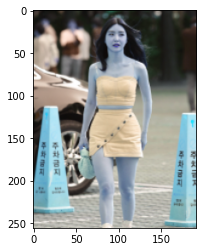

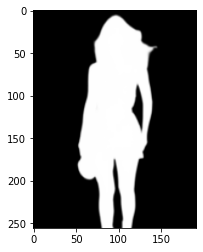

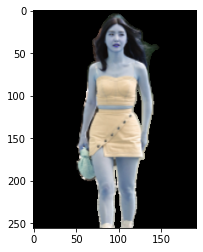

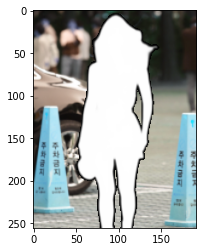

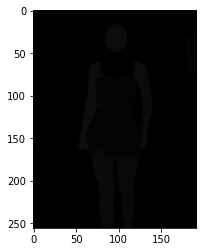

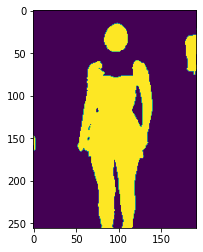

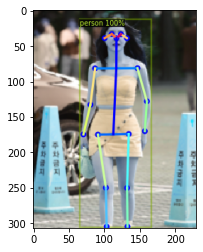

In [41]:
img_files_names = sorted(os.listdir(img_dir))

for img_name in img_files_names:
    #원본 이미지 불러오기
    img = cv2.imread(img_dir + img_name)
    edge_img = cv2.imread(edge_save_dir + img_name.replace('.jpg','.png'))
    label_img = cv2.imread(label_save_dir + img_name.replace('.jpg','.png'))
    #plt.imshow(img)
    #plt.show()
    
    #이미지의 BBox를 먼저 구하고, BBox의 사이즈를 기준으로 192 256으로 resize한다.
    outputs = predictor(img)

    #image resize
    obj, x, y, w, h, img, edge_img, label_img = onlykeeppersonclass(outputs, img, edge_img, label_img)
    
    #print(x, y, w, h)
   
    #setting resized images
    img_resized = img[y:y+h, x:x+w]
    edge_img_resized = edge_img[y:y+h, x:x+w]
    color_img_resized = np.where(edge_img_resized==(0,0,0) , edge_img_resized, img_resized)
    color_bg_img_resized = np.where(edge_img_resized==(0,0,0) ,img_resized, edge_img_resized)
    label_img_resized = label_img[y:y+h, x:x+w]
    label_img_resized_gray = cv2.cvtColor(label_img_resized, cv2.COLOR_BGR2GRAY)
    _, label_img_resized_th = cv2.threshold(label_img_resized_gray, 1, 255,cv2.THRESH_BINARY)
    

    #img show
    plt.imshow(img_resized)
    plt.show()
    plt.imshow(edge_img_resized)
    plt.show() 
    plt.imshow(color_img_resized)
    plt.show()
    plt.imshow(color_bg_img_resized)
    plt.show()
    plt.imshow(label_img_resized)
    plt.show()
    plt.imshow(label_img_resized_th)
    plt.show()
    
    pose_img_resized = detector.onImage(img_resized)
    
    #img save
    cv2.imwrite(img_save_dir+img_name, img_resized)
    cv2.imwrite(edge_resized_save_dir+img_name, edge_img_resized)
    cv2.imwrite(color_resized_save_dir+img_name, color_img_resized)
    cv2.imwrite(color_bg_resized_save_dir+img_name, color_bg_img_resized)
    cv2.imwrite(label_resized_save_dir+img_name, label_img_resized)
    cv2.imwrite(pose_resized_img_save_dir+img_name, pose_img_resized) #시간 오래걸림
    #cv2.imwrite(img_save_dir+img_name, sharpened)
    
    
    #192 256으로 resize된 이미지에서 pose estimation을 수행한다 -> 이 결과를 바탕으로 상반신 하반신 나누려 한다.
    make_annot(img_save_dir,pose_resized_save_dir)
    
    #192 256으로 resize된 이미지에서 human segmentation을 수행한다.
    
    
    
    
    

# human segmentation 수행

(953, 600, 3)
/aiffel/aiffel/aiffeltonprj/detectron/detectron2/datasets/new_datasets/test_label/yuna.png


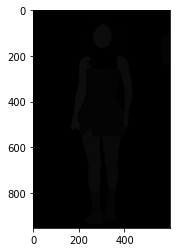

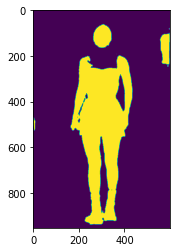

In [38]:
label = cv2.imread(label_save_dir+img_name.replace('.jpg','.png'))
print(label.shape)
print(label_save_dir+img_name.replace('.jpg','.png'))
plt.imshow(label)
plt.show()

label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
_, label_th = cv2.threshold(label, 1, 255,cv2.THRESH_BINARY)
plt.imshow(label_th)
plt.show()
